# Importowanie bibliotek

In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv
from collections import Counter
from sklearn.metrics import roc_curve, auc
import math


# Wczytywanie danych iris

In [2]:
iris = datasets.load_iris()
df = pd.DataFrame(iris.data)
df['target'] = iris.target
df

,0,1,2,3,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


# Projekcja danych na przestrzeń dwuwymiarową

In [3]:
def project_data(df):
    covariance_matrix = df.cov()
    values, vectors = np.linalg.eig(covariance_matrix)
    top_vectors = vectors[:, :2]
    projected = df.dot(top_vectors)
    return projected

In [4]:
X_0 = df[df['target'] == 0].drop(columns = ['target'])
X_1 = df[df['target'] == 1].drop(columns = ['target'])

X_0 = project_data(X_0)
X_1 = project_data(X_1)
for i, row in X_1.iterrows():
    row -= [12, 1]
    
X = pd.concat([X_0, X_1])  
y = df[df['target'] < 2]['target']

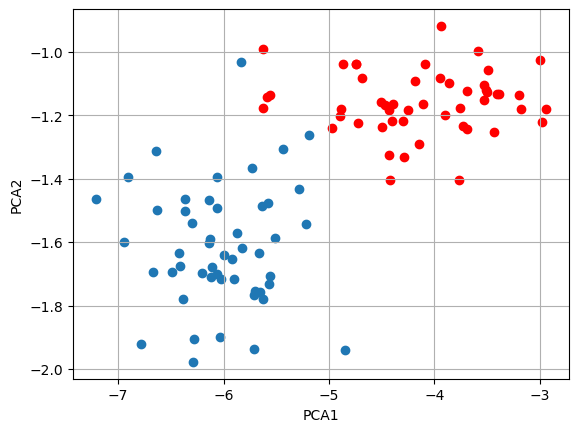

In [5]:
plt.scatter(X_0[0], X_0[1])
plt.scatter(X_1[0], X_1[1], color='red')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid()
plt.show()

#  Klasyfikator Fishera

In [6]:
def get_scatter_matrix(data, mean):
    scatter_matrix = np.array([[0.0, 0.0], [0.0, 0.0]])
    for index, row in data.iterrows():
        term = np.outer(row-mean, row-mean)
        scatter_matrix += term
    return scatter_matrix


def calculate_fisher_vector(projected0, projected1):
    mean0 = np.mean(projected0, axis=0)
    mean1 = np.mean(projected1, axis=0)
    scatter0 = get_scatter_matrix(projected0, mean0)
    scatter1 = get_scatter_matrix(projected1, mean1)
    Sw = scatter0 + scatter1
    Sw_inv = inv(Sw)
    w = np.dot(Sw_inv, (mean1-mean0).transpose())
    return w


def project_point_onto_vector(point, vector):
    norm = np.linalg.norm(vector)
    vector /= norm
    projection = np.dot(point, vector) * vector
    return projection


def get_projected_points(data, w):
    double_projected = []
    for index, row in data.iterrows():
        projected_point = project_point_onto_vector(row, w)
        double_projected.append(projected_point)
    double_projected = np.array(double_projected)
    double_projected = double_projected[double_projected[:, 0].argsort()]
    return double_projected


def combine_projected(double_projected0, double_projected1):
    arr1_num = np.ones_like(double_projected1[:, 0])
    arr2_num = 2 * np.ones_like(double_projected0[:, 0])
    combined = np.column_stack((np.concatenate((double_projected1[:, :2],double_projected0[:, :2])), np.concatenate((arr1_num, arr2_num))))
    combined = combined[combined[:, 0].argsort()]
    return combined


def calculate_split(combined):    
    jedynki = 0
    pref = []
    for i in range(len(combined)):
        if(combined[i][2] == 2):
            jedynki += 1
        pref.append(jedynki)

    best_mistakes = len(combined)
    best_index = i

    for i in range(len(combined)):
        mistakes = (i+1-pref[i]) + (pref[-1] - pref[i])
        if mistakes < best_mistakes:
            best_mistakes = mistakes
            best_index = i
    split = (combined[best_index] + combined[best_index+1])[0:2]/2
    return split
    
def fit_fisher(projected0, projected1):
    w = calculate_fisher_vector(projected0, projected1)
    double_projected0 = get_projected_points(projected0, w)
    double_projected1 = get_projected_points(projected1, w)
    combined = combine_projected(double_projected0, double_projected1)
    split = calculate_split(combined)
    A, B = w
    C = -np.dot(w, split)
    return A, B, C

In [7]:
def classify_fisher(X_train, y_train, X_test):
    data = pd.DataFrame(np.column_stack((np.array(X_train), np.array(y_train))), columns=['x', 'y', 'class'])
    data0 = data[data['class'] == 0].drop(columns = ['class'])
    data1 = data[data['class'] == 1].drop(columns = ['class'])
    
    A, B, C = fit_fisher(data0, data1)
    
    y =  (-A *X_test[0] - C) / B
    if y >= X_test[1]:
        return 0
    return 1
    

# Walidacja klasyfikatora Fishera przy użyciu leave-one-out

In [8]:
def evaluate_fisher(X, y):
    correct_predictions = 0
    y_true = []
    y_scores = []

    for i in range(len(X)):
        X_test = X[i]
        y_test = y[i]
        
        mask = np.ones(len(X), dtype=bool)
        mask[i] = False
        
        X_train = X[mask]
        y_train = y[mask]

        predicted_class = classify_fisher(X_train, y_train, X_test)
        if predicted_class == y_test:
            correct_predictions += 1
            
        y_true.append(1 if y_test == 1 else 0)
        y_scores.append(predicted_class)

    accuracy = correct_predictions / len(X)
    
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=('ROC curve (area = {:.2f})').format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return accuracy, roc_auc

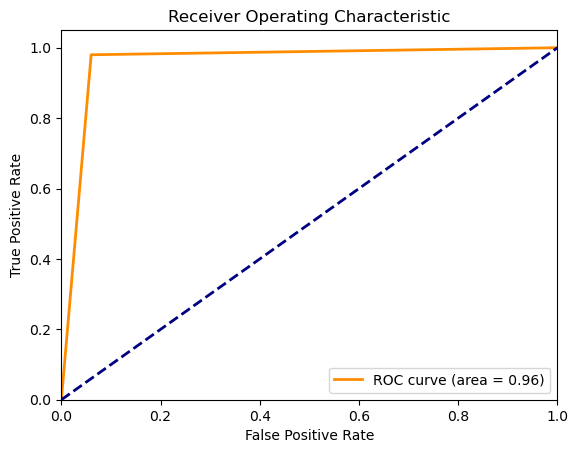

(0.96, 0.96)

In [9]:
evaluate_fisher(np.array(X), np.array(y))

# Klasyfikator KNN

In [10]:
def euclidean_distance(point1, point2):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))

def classify_knn(X_train, y_train, test_point, k):
    distances = [euclidean_distance(test_point, train_point) for train_point in X_train]
    sorted_indices = sorted(range(len(distances)), key=lambda k: distances[k])
    k_nearest_labels = [y_train[i] for i in sorted_indices[:k]]
    most_common_label = Counter(k_nearest_labels).most_common(1)[0][0]
    return most_common_label

# Walidacja klasyfikatorów KNN za pomocą leave-on-out

In [11]:
def evaluate_knn(X, y, k):
    correct_predictions = 0
    y_true = []
    y_scores = []

    for i in range(len(X)):
        X_test = X[i]
        y_test = y[i]

        mask = np.ones(len(X), dtype=bool)
        mask[i] = False

        X_train = X[mask]
        y_train = y[mask]

        predicted_class = classify_knn(X_train, y_train, X_test, k)
        if predicted_class == y_test:
            correct_predictions += 1

        y_true.append(1 if y_test == 1 else 0)
        y_scores.append(predicted_class)

    accuracy = correct_predictions / len(X)

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=('ROC curve for k ='+ str(k) + ' (area = {:.2f})').format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy, roc_auc

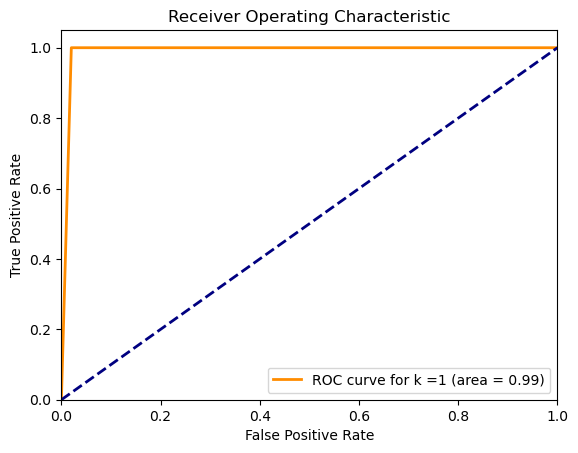

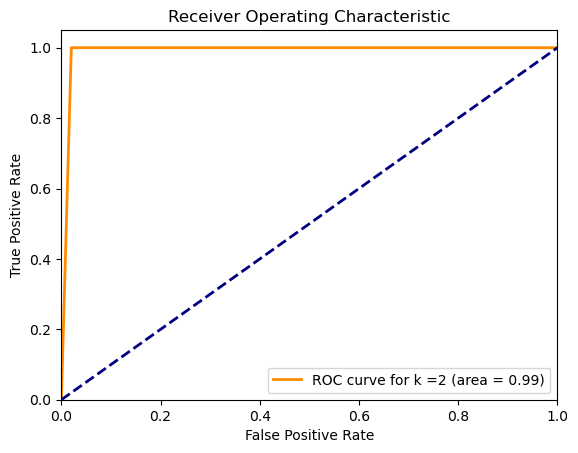

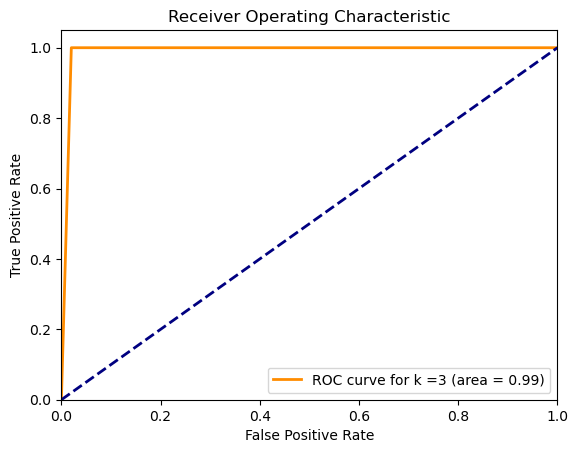

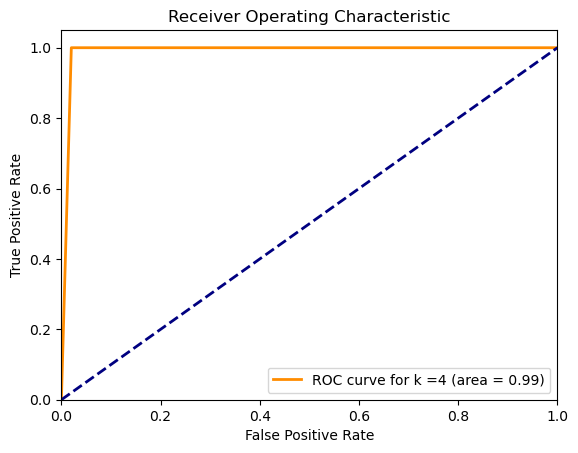

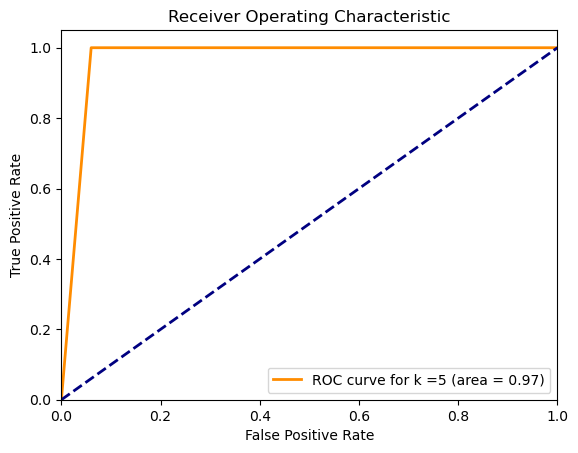

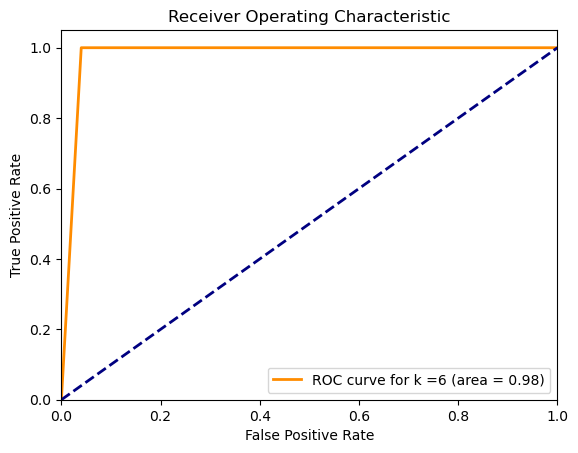

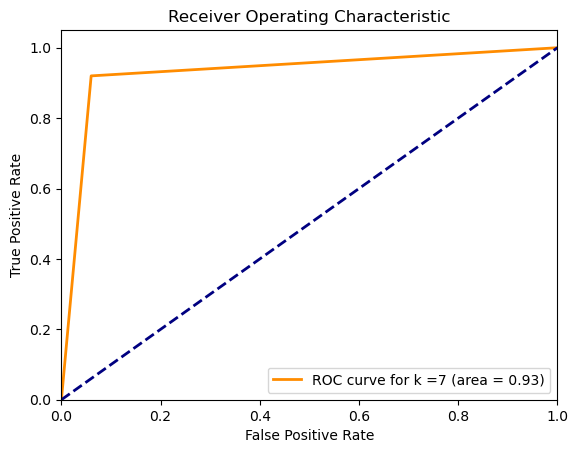

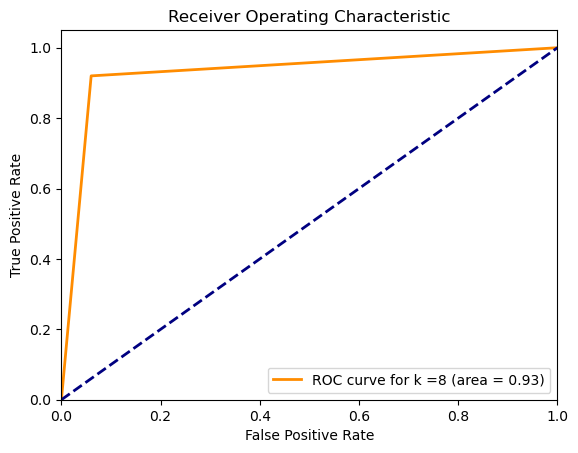

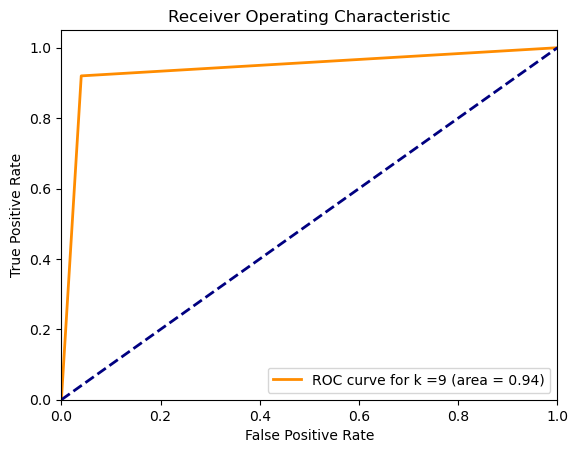

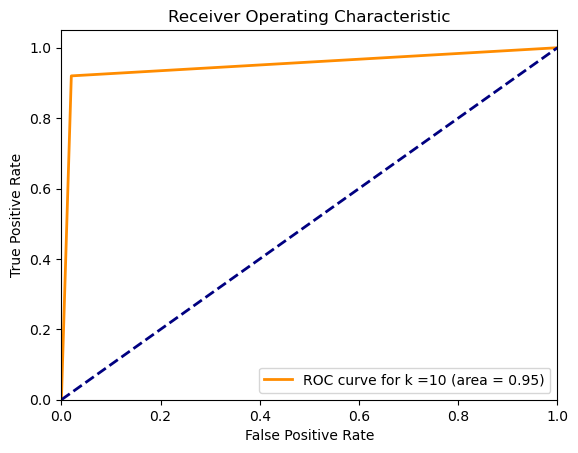

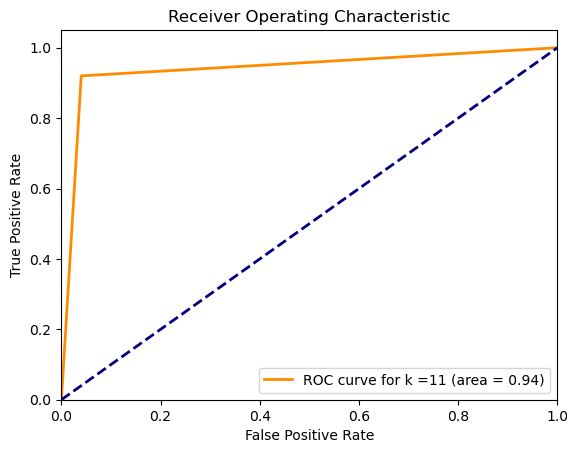

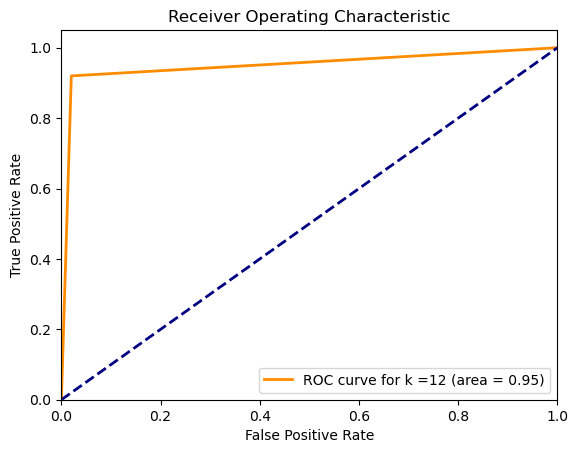

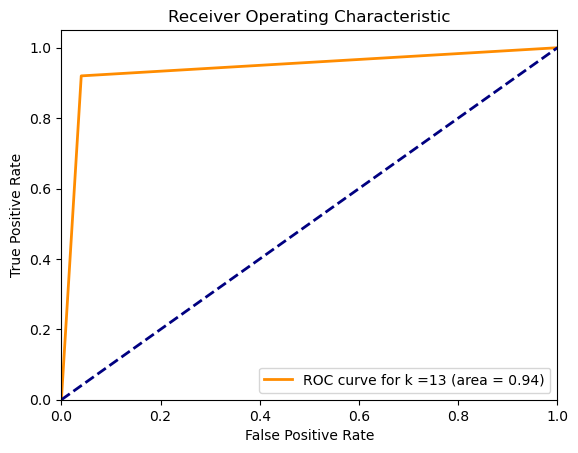

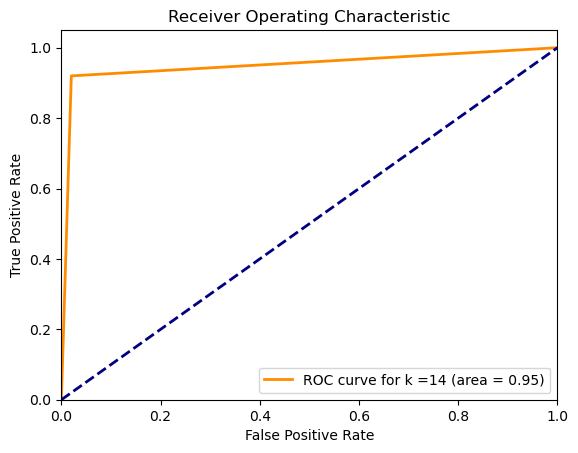

[(0.99, 0.99),
 (0.99, 0.99),
 (0.99, 0.99),
 (0.99, 0.99),
 (0.97, 0.97),
 (0.98, 0.98),
 (0.93, 0.9299999999999998),
 (0.93, 0.9299999999999998),
 (0.94, 0.94),
 (0.95, 0.95),
 (0.94, 0.94),
 (0.95, 0.95),
 (0.94, 0.94),
 (0.95, 0.95)]

In [12]:
[evaluate_knn(np.array(X), np.array(y), k) for k in range(1, 15)]